# Aprendizado Profundo - Introdução ao Aprendizado de Máquina

- Neste notebook, iremos rever conceitos importantes referentes à Aprendizagem de Máquina, como problemas de regressão vs. classificação, divisão dos dados em conjuntos de treino, validação e teste e avaliação dos modelos utilizados (métricas de precisão e revocação, por exemplo). Iremos utilizar basicamente dois *toy-datasets* que podem ser encontrados na documentação da biblioteca `scikit-learn`, sendo eles a base de dados [Iris](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_iris.html#sklearn.datasets.load_iris), para classificação, e de [Diabetes](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_diabetes.html#sklearn.datasets.load_diabetes), para regressão.

## 1. Conjunto de Exercícios - Carregamento das bases de dados

- Para começarmos a revisão de aprendizagem de máquina, primeiro devemos ser capazes de carregar as bases de dados em memória. Iremos definir em detalhes um *pipeline* de processamento completo, ou seja, desde o carregamento dos dados até o treinamento dos modelos, para a base de dados Iris, e a sua tarefa, posteriormente, será de replicar as mesmas ideias para a base de dados de Diabetes.



In [1]:
# Importando as funções para carregar os dados em memória
from sklearn.datasets import load_iris, load_diabetes

In [2]:
# Podemos brincar com alguns parâmetros presentes na documentação.
# Aqui, iremos carregar os dados como tabelas Pandas, apenas para uma visualização mais limpa.

X, y = load_iris(return_X_y=True, as_frame=True)

In [3]:
X.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [4]:
y.head()

,target
0,0
1,0
2,0
3,0
4,0


## 2. Conjunto de Exercícios - Divisão entre treino/validação/teste

- Como visto em sala de aula, tipicamente separamos os dados em 3 conjuntos: Treino, Validação e Teste, onde cada um deles possuem um propósito específico, como podemos ver a seguir:
    - **Treino:** Como o nome diz, esse conjunto dos dados serve para treinarmos os nossos modelos. Em outras palavras, encontrar os pesos dos nossos modelos que minimizam um certo erro;

    - **Validação:** Como o nome diz, esse conjunto dos dados serve para validarmos os nossos modelos. Tipicamente, quando trabalhamos com aprendizagem de máquina, temos diversos modelos com hiperparâmetros que devemos otimizar de acordo com os nossos dados, como por exemplo: a profundidade de uma árvore, o número de vizinhos de um KNN, entre outros. Para isso, utilizamos o conjunto de validação para verificar qual variação dos hiperparâmetros do nosso modelo é a mais promissora;
    
    - **Teste:** O conjunto de teste é o conjunto que não iremos utilizar nem durante o treinamento nem durante a a validação do nosso modelo. O intuito desse conjunto de dados é representar dados novos, que o nosso modelo não viu ainda, a fim de mensurar a qualidade das nossas predições em dados reais.

1. Utilizando a função [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html), divida os dados carregados anteriormente em dois conjunos: treino e teste. Posteriormente, iremos definir o conjunto de validação utilizando validação cruzada em N-Folds, durante o treinamento dos nossos modelo.

**Dica:** Após implementar o treinamento dos modelos, volte nessa célula e brinque com a porcentagem dos dados que serão destinados para o conjunto de treino e teste. Além disso, para fins de reprodutibilidade, sugerimos que você defina um `random_state`, para evitar eventuais dores de cabeça com resultados inconsistentes.
- Uma outra dica útil é realizar um `shuffle` durante a divisão dos dados, já que as *labels* nessa base de dados estão agrupadas, introduzindo assim um potencial desbalanceamento de classes nos conjuntos. Leia a documentação da função para obter mais informações sobre como realizar esse `shuffle`.

In [5]:
from sklearn.model_selection import train_test_split

# Convertendo os valores para matrizes e vetores numpy

# Implemente a sua solução aqui
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, shuffle=True)

2. Implemente também uma visualização da distribuição das classes nos dois conjuntos de dados através de gráficos de barra, utilizando a biblioteca `matplotlib`.

**Dica:** Utilize a classe `Counter` do módulo `collections`, nativo do Python, para contar quantas classes temos nas anotações de cada conjunto.

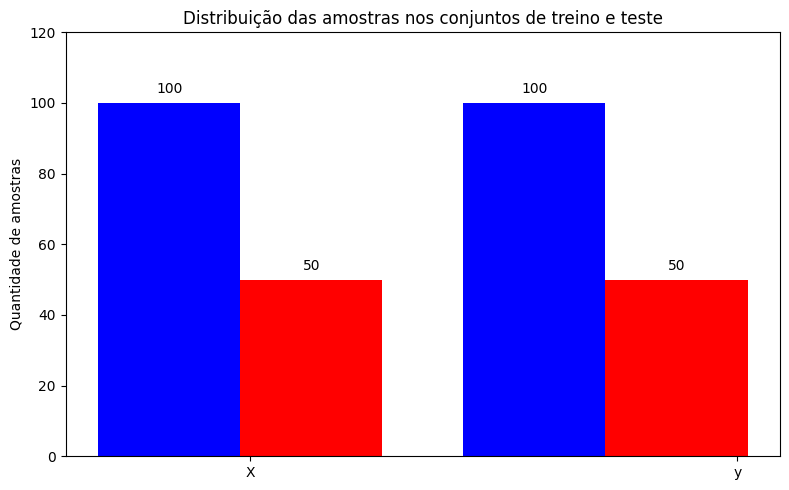

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# Função auxiliar para ordenar um dicionário baseado nas chaves (caso precise)
def sort_dict(d):
    return {key: d[key] for key in sorted(d)}

# Implemente a sua solução aqui

valores = [len(X_train), len(X_test), len(y_train), len(y_test)]
labels = ['X_train', 'X_test', 'y_train', 'y_test']
cores = ['blue', 'red', 'blue', 'red']

# Posições customizadas para colar os pares
x_pos = [0, 0.35, 0.9, 1.25]  # X_train/X_test juntos, depois y_train/y_test juntos

# Plot
plt.figure(figsize=(8, 5))
bars = plt.bar(x_pos, valores, color=cores, width=0.35)

# Eixos e título
plt.ylim(0, 120)
plt.ylabel('Quantidade de amostras')
plt.title('Distribuição das amostras nos conjuntos de treino e teste')

# Adicionando os rótulos personalizados no eixo X
plt.xticks([0.2, 1.4], ['X', 'y'])  # Centraliza os pares com labels genéricos

# Mostrar os valores em cima das barras
for bar in bars:
    altura = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, altura + 2, f'{int(altura)}',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

## 3. Conjunto de Exercícios - Treinamento dos modelos

- Como mencionado anteriormente, durante o treinamento dos modelos iremos utilizar uma validação cruzada com N-Folds. Além disso, iremos explorar 3 modelos clássicos durante os nossos exercícios, sendo eles: (i) Naive Bayes, que servirá como *baseline* para comparações futuras; (ii) árvores de decisão, podendo ficar livre para explorar "variantes" *ensemble* como no caso de modelos de *bagging* e *boosting*; e finalmente (iii) K-Nearest Neighbors.

In [7]:
# Definindo todos os imports necessários para esse conjunto de exercícios
# Caso necessário, inclua outros imports (principalmente se quiserem trabalhar com outros modelos)
from sklearn.model_selection import KFold

from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

1. Instancie um objeto da classe `KFold`, passando o número de *folds* que deseja utilizar durante o processo de validação cruzada (sugerimos um valor de 5 *folds*, mas fique a vontade para testar outros valores).

**Dica:** A mesma dica de definir um `random_state` se aplica também durante a definição do seu objeto da classe `KFold` se desejar habilitar a opção de `shuffle` da classe.

In [8]:
# Implemente a sua solução aqui

kf = KFold(n_splits=5, shuffle=True, random_state=42)

2. Treine o modelo Naive Bayes utilizando os dados de treino para realizar o loop de validação cruzada. Como o modelo a ser utilizado não possui hiperparâmetros, ele servirá como um ótimo *baseline* para o nosso problema.

**Dica:** Para mensurar a qualidade do seu modelo, utilize as métricas: acurácia, revocação e precisão. A biblioteca `sklearn` implementa tais funções, mas, caso queira, sinta-se a vontade para implementar as suas próprias funções para tais métricas.

In [9]:
# Caso queira utilizar as implementações padrões da biblioteca para as métricas
# Caso for utilizar precision e recall_score, lembre-se de definir o parâmetro 'average' para None. Dessa forma,
# as métricas serão calculadas para cada classe, ao invés de realizarmos algum tipo de sumarização.
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score

modelo = GaussianNB()
modelo.fit(X_train, y_train)

y_pred = modelo.predict(X_test)
y_test_lista = y_test.values.tolist()

acc = accuracy_score(y_test_lista, y_pred)
print("Accuracy: " + str(acc))

prob = 1
recall = recall_score(y_test_lista, y_pred, average=None)
for reacal in recall:
  prob *= reacal
print("Recall: " + str(prob))

prob = 1
precision = precision_score(y_test_lista, y_pred, average=None)
for precision in precision:
  prob *= precision
print("Precision: " + str(prob))

Accuracy: 0.96
Recall: 0.875
Precision: 0.875


- Utilize o seguinte trecho de código para implementar a validação cruzada utilizando N-Folds. Você pode utilizar `train_index` e `validation_index` para indexar as variáveis `X_train` e `y_train` para obter os conjuntos de treino e validação, respectivamente, da sua validação cruzada!

```python
# kf é um objeto da classe KFold
for i, (train_index, validation_index) in enumerate(kf.split(X_train)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Validation:  index={validation_index}")
```



In [10]:
# Implemente a sua solução aqui
for i, (train_index, validation_index) in enumerate(kf.split(X_train)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Validation:  index={validation_index}")

    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[validation_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[validation_index]

    y_pred = modelo.predict(X_val_fold)

    acc = accuracy_score(y_val_fold, y_pred)
    recall = recall_score(y_val_fold, y_pred, average=None)
    precision = precision_score(y_val_fold, y_pred, average=None)

    print("Accuracy: " + str(acc))

    prob = 1
    recall = recall_score(y_val_fold, y_pred, average=None)
    for reacal in recall:
      prob *= reacal
    print("Recall: " + str(prob))

    prob = 1
    precision = precision_score(y_val_fold, y_pred, average=None)
    for precision in precision:
      prob *= precision
    print("Precision: " + str(prob))
    print('_______________________________________________')

Fold 0:
  Train: index=[ 1  2  3  5  6  7  8  9 11 13 14 15 16 17 19 20 21 23 24 25 26 27 28 29
 32 34 35 36 37 38 40 41 42 43 46 47 48 49 50 51 52 54 55 56 57 58 59 60
 61 62 63 64 65 66 67 68 69 71 72 74 75 78 79 81 82 84 85 86 87 88 89 91
 92 93 94 95 96 97 98 99]
  Validation:  index=[ 0  4 10 12 18 22 30 31 33 39 44 45 53 70 73 76 77 80 83 90]
Accuracy: 0.95
Recall: 0.875
Precision: 0.9
_______________________________________________
Fold 1:
  Train: index=[ 0  1  2  3  4  6  7  8 10 12 13 14 17 18 19 20 21 22 23 24 25 27 29 30
 31 32 33 34 36 37 38 39 41 43 44 45 46 48 49 50 51 52 53 54 56 57 58 59
 60 61 62 63 64 67 68 70 71 73 74 75 76 77 78 79 80 81 82 83 84 86 87 89
 90 91 92 94 95 97 98 99]
  Validation:  index=[ 5  9 11 15 16 26 28 35 40 42 47 55 65 66 69 72 85 88 93 96]
Accuracy: 0.9
Recall: 0.675
Precision: 0.675
_______________________________________________
Fold 2:
  Train: index=[ 0  1  2  4  5  9 10 11 12 14 15 16 18 20 21 22 23 26 28 29 30 31 32 33
 35 37 39 40 41 4

3. Utilizando o mesmo *pipeline* de treinamento, treine agora um modelo baseado em Árvore de Decisão de K-Nearest Neighbors. Como hiperparâmetros, experimente variar a profundidade da sua árvore de decisão e o número de vizinhos mais próximos que o algoritmo de KNN deve considerar para as estimações.

**Dica:** Após cada loop por todos os *folds* da validação cruzada, tire a média das métricas para obter uma sumarização da qualidade do seu modelo ao utilizar um valor de hiperparâmetro específico. É recomendado você fazer um plot para aumentar a interpretação dos resultados, onde o eixo-x pode ser, por exemplo, o valor do hiperparâmetro e o eixo-y a acurácia tanto nos dados de treino quanto nos dados de validação.

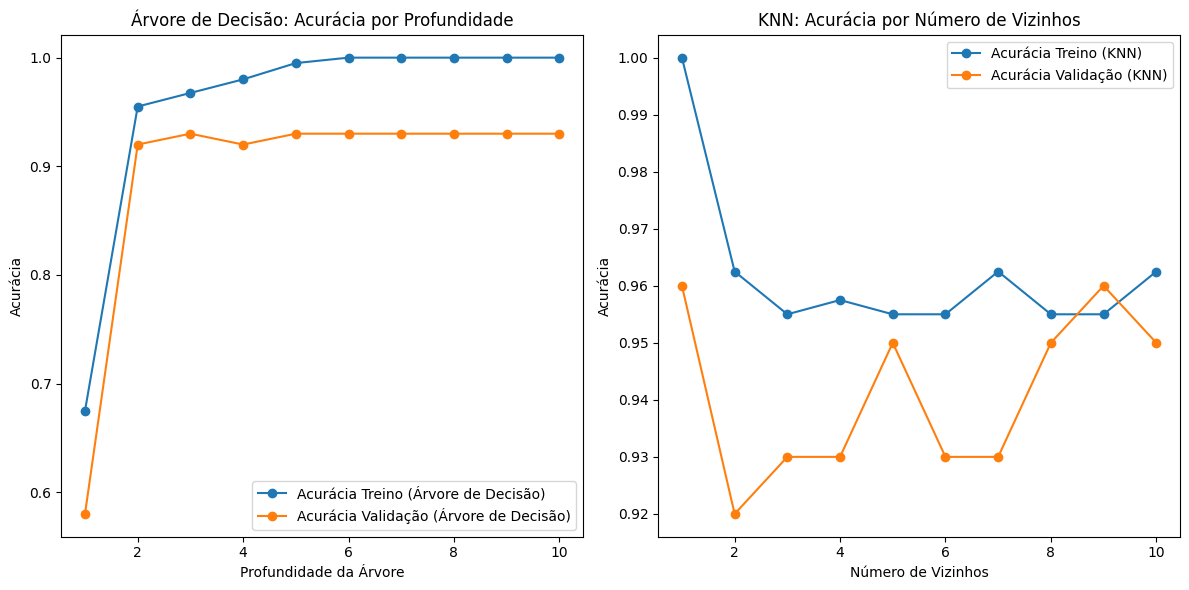

In [11]:
# Implemente a sua solução aqui
def treinar_e_calcular(modelo, X_train, y_train, kf):
    accuracies_train = []
    accuracies_val = []

    for train_index, validation_index in kf.split(X_train):
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[validation_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[validation_index]

        modelo.fit(X_train_fold, y_train_fold)

        y_train_pred = modelo.predict(X_train_fold)
        accuracies_train.append(accuracy_score(y_train_fold, y_train_pred))

        y_val_pred = modelo.predict(X_val_fold)
        accuracies_val.append(accuracy_score(y_val_fold, y_val_pred))

    media_train_accuracy = np.mean(accuracies_train)
    media_val_accuracy = np.mean(accuracies_val)

    return media_train_accuracy, media_val_accuracy

max_profund = range(1, 11)
num_vizinhos = range(1, 11)

dt_train_accuracies = []
dt_val_accuracies = []
knn_train_accuracies = []
knn_val_accuracies = []

for max_depth in max_profund:
    modelo_dt = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    media_train, media_val = treinar_e_calcular(modelo_dt, X_train, y_train, kf)
    dt_train_accuracies.append(media_train)
    dt_val_accuracies.append(media_val)

for n_neighbors in num_vizinhos:
    modelo_knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    media_train, media_val = treinar_e_calcular(modelo_knn, X_train, y_train, kf)
    knn_train_accuracies.append(media_train)
    knn_val_accuracies.append(media_val)

plt.figure(figsize=(12, 6))

# Árvore de Decisão
plt.subplot(1, 2, 1)
plt.plot(max_profund, dt_train_accuracies, label='Acurácia Treino (Árvore de Decisão)', marker='o')
plt.plot(max_profund, dt_val_accuracies, label='Acurácia Validação (Árvore de Decisão)', marker='o')
plt.xlabel('Profundidade da Árvore')
plt.ylabel('Acurácia')
plt.title('Árvore de Decisão: Acurácia por Profundidade')
plt.legend()

# KNN
plt.subplot(1, 2, 2)
plt.plot(num_vizinhos, knn_train_accuracies, label='Acurácia Treino (KNN)', marker='o')
plt.plot(num_vizinhos, knn_val_accuracies, label='Acurácia Validação (KNN)', marker='o')
plt.xlabel('Número de Vizinhos')
plt.ylabel('Acurácia')
plt.title('KNN: Acurácia por Número de Vizinhos')
plt.legend()

plt.tight_layout()
plt.show()


4. Sumarize os seus resultados. Qual modelo que você utilizou obteve o melhor resultado? Para isso, escolha os melhores modelos obtidos através da validação cruzada e avalie eles utilizando o conjunto de teste. O resultado condiz com as suas expectativas?

In [12]:
modelo_nb = GaussianNB()
modelo_nb.fit(X_train, y_train)
y_pred_nb = modelo_nb.predict(X_test)
acc_nb = accuracy_score(y_test, y_pred_nb)
print(f"Accuracy do Naive Bayes no conjunto de teste: {acc_nb}")

modelo_dt = DecisionTreeClassifier(max_depth=6, random_state=42)
modelo_dt.fit(X_train, y_train)
y_pred_dt = modelo_dt.predict(X_test)
acc_dt = accuracy_score(y_test, y_pred_dt)
print(f"Accuracy da Árvore de Decisão no conjunto de teste: {acc_dt}")

modelo_knn = KNeighborsClassifier(n_neighbors=9)
modelo_knn.fit(X_train, y_train)
y_pred_knn = modelo_knn.predict(X_test)
acc_knn = accuracy_score(y_test, y_pred_knn)
print(f"Accuracy do KNN no conjunto de teste: {acc_knn}")

Accuracy do Naive Bayes no conjunto de teste: 0.96
Accuracy da Árvore de Decisão no conjunto de teste: 0.98
Accuracy do KNN no conjunto de teste: 0.98


Pelos resultados anteriores, eu imaginava que o modelo Naive Bayes seria o melhor, dado ao seu valor alto e estabilidade. Porém, o código acima demonstra uma superioridade da Árvore de decisão e da KNN

5. **Extra:** Ainda utilizando o conjunto de teste, para enriquecer os seus resultados, plote uma matriz de confusão para cada modelo.

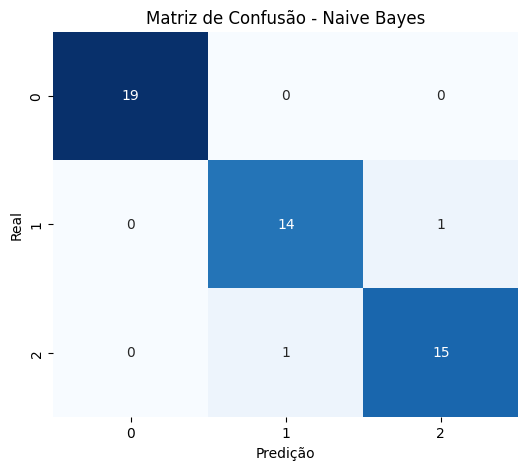

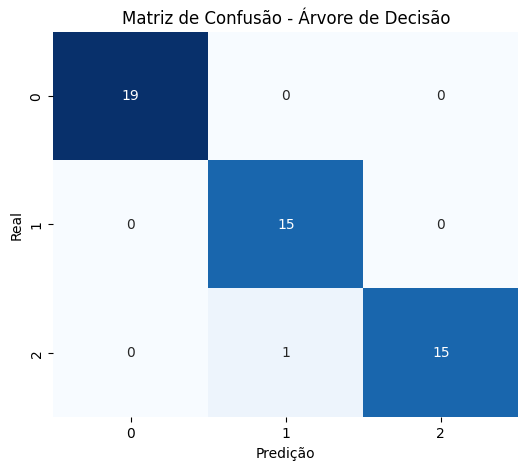

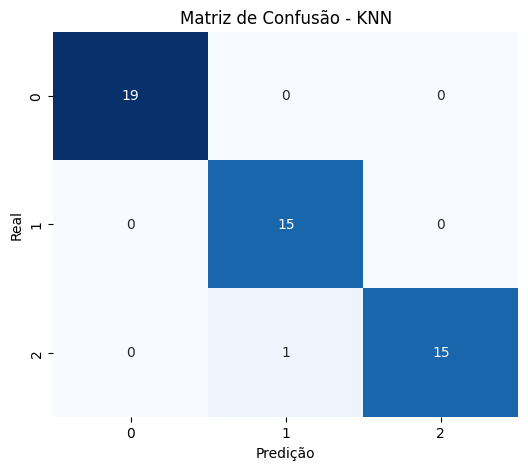

In [13]:
import seaborn as sns # para visualização da matriz de confusão
from sklearn.metrics import confusion_matrix # para geração da matriz de confusão

# Implemente a sua solução aqui

def plot_confusion_matrix(modelo, X_test, y_test, title="Matriz de Confusão"):
    # Gerar a matriz de confusão
    y_pred = modelo.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    # Plotando a matriz de confusão
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=modelo.classes_, yticklabels=modelo.classes_)
    plt.title(title)
    plt.xlabel('Predição')
    plt.ylabel('Real')
    plt.show()

plot_confusion_matrix(modelo_nb, X_test, y_test, "Matriz de Confusão - Naive Bayes")

plot_confusion_matrix(modelo_dt, X_test, y_test, "Matriz de Confusão - Árvore de Decisão")

plot_confusion_matrix(modelo_knn, X_test, y_test, "Matriz de Confusão - KNN")

## 4. Conjunto de Exercícios - Tarefa de Regressão (desafio)

- Agora é com você! Repita os mesmos passos definidos para a tarefa de classificação sobre os dados da tarefa de regressão (base de dados de diabetes). Fique atento às nuâncias que existem entre os dois tipos de problemas, principalmente aos modelos que irá utilizar e as métricas! Sinta-se livre para explorar outros *pipelines*, preprocessamentos, e até mesmo uma outra base de dados! A ideia deste exercício é fazer com que você coloque a mão na massa por conta própria, enfrentando os problemas que encontrar ao longo do caminho.

In [14]:
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

diabetes = load_diabetes()

X = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)
y = pd.Series(diabetes.target, name='Target')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    return mse, r2

modelo = LinearRegression()

resultados_mse = []
resultados_r2 = []

for train_index, validation_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[validation_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[validation_index]

    mse, r2 = evaluate_model(modelo, X_train_fold, y_train_fold, X_val_fold, y_val_fold)
    resultados_mse.append(mse)
    resultados_r2.append(r2)

print(f"Erro quadrático médio para Regressão Linear: {sum(resultados_mse) / len(resultados_mse)}")
print(f"R² para Regressão Linear: {sum(resultados_r2) / len(resultados_r2)}")

Erro quadrático médio para Regressão Linear: 3271.0135309477323
R² para Regressão Linear: 0.4202806662546667
